### 1 Training Data Preparation

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from scipy.stats import normaltest

# Load and clean data
data = pd.read_csv('train_data.csv')
data.columns = data.columns.str.strip()
labels = data['Bankrupt?']

# Ensure only necessary columns are used
data = data.drop(columns=['Bankrupt?', 'Index'])

# Scaling data using RobustScaler to minimize the impact of outliers
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data.select_dtypes(include=[np.number]))
data_scaled = pd.DataFrame(data_scaled, columns=data.select_dtypes(include=[np.number]).columns)

# Combining highly correlated features
composite_features = {
    'Liability_Composite': (data_scaled['Current Liabilities/Liability'] + data_scaled['Current Liability to Liability']) / 2,
    'Net_Value_Per_Share_BC': (data_scaled['Net Value Per Share (B)'] + data_scaled['Net Value Per Share (C)']) / 2,
    'Interest_Rate_Composite': (data_scaled['Pre-tax net Interest Rate'] + data_scaled['After-tax net Interest Rate']) / 2,
    'Gross_Margin_Composite': (data_scaled['Operating Gross Margin'] + data_scaled['Gross Profit to Sales']) / 2,
    'EPS_Net_Profit_Composite': (data_scaled['Persistent EPS in the Last Four Seasons'] + data_scaled['Per Share Net profit before tax (Yuan ¥)']) / 2
}
data_scaled = data_scaled.assign(**composite_features)
data_scaled.drop(columns=list(composite_features.keys()), inplace=True)

# Normality check and transformation
for column in data_scaled.columns:
    _, p = normaltest(data_scaled[column])
    if p < 0.05:  # Not normal
        # Clipping data to avoid extremes before transformation
        clipped_data = np.clip(data_scaled[column], -10, 10)
        transformer = PowerTransformer(method='yeo-johnson')
        data_scaled[column] = transformer.fit_transform(clipped_data.values.reshape(-1, 1))

# Apply PCA to ensure no more than 50 components and at least 95% variance retention
pca = PCA(n_components=0.95)
transformed_data = pca.fit_transform(data_scaled)

if pca.n_components_ > 50:
    pca = PCA(n_components=50)
    transformed_data = pca.fit_transform(data_scaled)

print(f"Components used: {pca.n_components_}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_)}")


Components used: 40
Explained variance ratio: 0.9533278841966508


### 2 Company Characterization

C:\Users\justi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


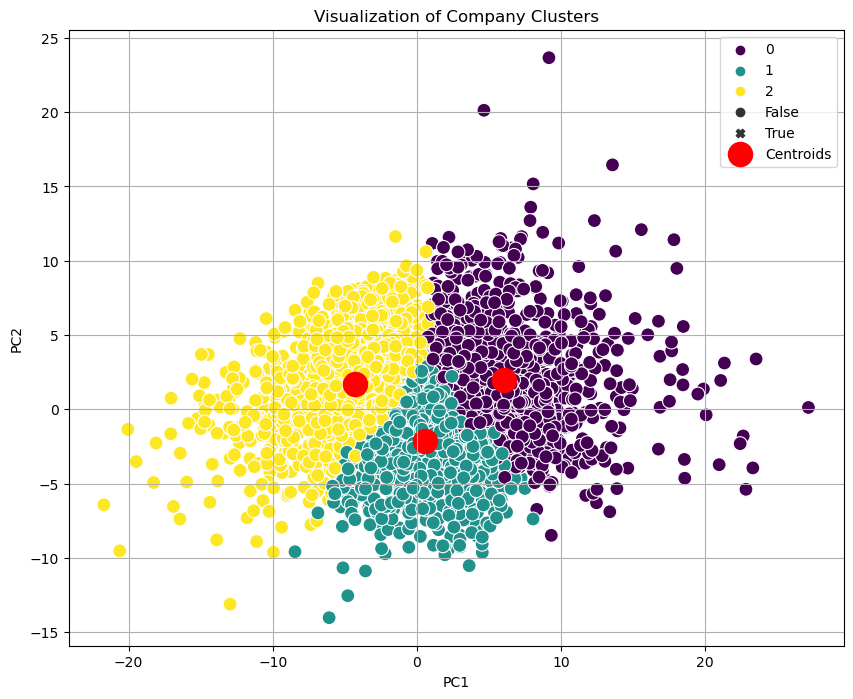

[0 1 2 ... 1 2 2]


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

# recall: 'transformed_data' is the PCA reduced data
# number of clusters (k) 
k = 3

# initialize KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)

# fit KMeans to the transformed data
clusters = kmeans.fit_predict(transformed_data)

# 'clusters' contains the cluster IDs assigned by KMeans to each data point

pca_df = pd.DataFrame(transformed_data, columns=[f'PC{i+1}' for i in range(transformed_data.shape[1])])
pca_df['Cluster_ID'] = clusters  # clusters obtained from KMeans

# calculating cluster centers directly from PCA data for accurate plotting
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(kmeans.cluster_centers_.shape[1])])
cluster_centers['Cluster_ID'] = range(k)  # Assign unique IDs to cluster centers for plotting

# combining data and cluster centers for plotting
plot_data = pd.concat([pca_df, cluster_centers], ignore_index=True)

# visualization using the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_ID', data=plot_data, style=plot_data.index >= len(pca_df), palette='viridis', s=100)
plt.scatter(cluster_centers['PC1'], cluster_centers['PC2'], s=300, c='red', label='Centroids')  # Highlight centroids
plt.title('Visualization of Company Clusters')
plt.legend()
plt.grid(True)
plt.show()
print(clusters)


### 3 Train Model 1: Stacking Method

#### 1. Build a model that predicts a group a company will likely belong to using any supervised learning algorithm. The prediction’s accuracy should be high, and it is okay to overfit. Identify the features that play important roles in this prediction.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

original_features = data_scaled.columns.tolist()

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(transformed_data, clusters, test_size=0.2, random_state=42)

# Train a RandomForestClassifier to predict group membership
group_model = RandomForestClassifier(n_estimators=100, random_state=42)
group_model.fit(X_train, y_train)

# Predict group membership on the validation set
group_preds = group_model.predict(X_val)

# Feature importances
feature_importances = group_model.feature_importances_
important_features_indices = feature_importances.argsort()[-10:][::-1]  # Select top 10 important features

# Map indices to feature names
important_features = [original_features[index] for index in important_features_indices]
print("Top 10 Important Features:")
for feature in important_features:
    print(feature)
    
    
# Evaluate accuracy
group_accuracy = accuracy_score(y_val, group_preds)
print("\nGroup Membership Prediction Accuracy:", group_accuracy)

# Confusion matrix
group_conf_matrix = confusion_matrix(y_val, group_preds)
print("Confusion Matrix for Group Membership Prediction:")
print(group_conf_matrix)


Top 10 Important Features:
ROA(C) before interest and depreciation before interest
ROA(A) before interest and % after tax
Operating Expense Rate
Operating Gross Margin
Continuous interest rate (after tax)
Realized Sales Gross Margin
Operating Profit Rate
Cash flow rate
Long-term fund suitability ratio (A)
Pre-tax net Interest Rate

Group Membership Prediction Accuracy: 0.963855421686747
Confusion Matrix for Group Membership Prediction:
[[222   7   0]
 [  2 510  25]
 [  1   7 388]]


#### 2. Build a stacking model that predicts whether a company will file for bankruptcy.
a. Build base models using three non-parametric models. While the features in base models must be the same, the features used in each subgroup’s model do not have to be the same. 

b. Use a parametric model to build a meta-model. 

c. Each member should build a model for one or more subgroups. The member’s name, the subgroup(s) worked on, and the accuracy score must be reported. Provide the confusion matrix. See Table 2 for the format.


In [130]:
# a.
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score as acc_score, confusion_matrix,classification_report

# Train base models for each subgroup
base_models = {
    0: RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    1: GradientBoostingClassifier(n_estimators=100, random_state=42),
    2: KNeighborsClassifier(n_neighbors=5),
    #3: RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),

}



# Train and evaluate base models
for subgroup, model in base_models.items():
    # Subset data for the current subgroup
    subgroup_indices = np.where(clusters == subgroup)[0]
    X_subgroup, y_subgroup = transformed_data[subgroup_indices], data['Bankrupt?'].iloc[subgroup_indices]
    
    # Train base model
    model.fit(X_subgroup, y_subgroup)
    
    # Predict and evaluate accuracy
    subgroup_preds = model.predict(X_subgroup)
    subgroup_accuracy = acc_score(y_subgroup, subgroup_preds)  # Renamed variable
    subgroup_conf_matrix = confusion_matrix(y_subgroup, subgroup_preds)
    subgroup_class= classification_report(y_subgroup, subgroup_preds)
    
    # Calculate true positives (TT) and false positives (TF)
    if subgroup_conf_matrix.shape[0] < 2 or subgroup_conf_matrix.shape[1] < 2:
        tt, tf = 0, 0  # Set to 0 if one of the classes is missing
    else:
        tt = subgroup_conf_matrix[1][1] if subgroup_conf_matrix.shape[0] > 1 else 0  # True positives (TT)
        tf = subgroup_conf_matrix[1][0] if subgroup_conf_matrix.shape[1] > 1 else 0  # False positives (TF)
    
    # Calculate accuracy score (handle division by zero)
    if tt + tf == 0:
        accuracy = 0  # Set accuracy to 0 if both TT and TF are 0
    else:
        accuracy = tt / (tf + tt)  
    
    # Print metrics
    data_length = len(subgroup_indices)
    print(f"Subgroup: {subgroup}")
    print(f"Accuracy: {subgroup_accuracy}")
    print("Confusion Matrix:")
    print(subgroup_conf_matrix)
    print("Classification Report:")
    print(subgroup_class)
    print(f"Subgroup: {subgroup} - Train Data Length: {data_length}")
    print(f"Average Accuracy Score: {accuracy:.2f}")  
    print(f"TT: {tt}")
    print(f"TF: {tf}")
    print()


Subgroup: 0
Accuracy: 0.9758828596037898
Confusion Matrix:
[[1014    0]
 [  28  119]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1014
           5       1.00      0.81      0.89       147

    accuracy                           0.98      1161
   macro avg       0.99      0.90      0.94      1161
weighted avg       0.98      0.98      0.97      1161

Subgroup: 0 - Train Data Length: 1161
Average Accuracy Score: 0.81
TT: 119
TF: 28

Subgroup: 1
Accuracy: 0.9996249062265566
Confusion Matrix:
[[2615    0]
 [   1   50]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2615
           5       1.00      0.98      0.99        51

    accuracy                           1.00      2666
   macro avg       1.00      0.99      0.99      2666
weighted avg       1.00      1.00      1.00      2666

Subgroup: 1 - Train Data Length: 2666
Average

In [131]:
from sklearn.metrics import classification_report

meta_inputs = np.vstack(meta_inputs)
targets = np.concatenate(targets)

# Train and evaluate the meta-model
meta_model = LogisticRegression()
meta_model.fit(meta_inputs, targets)

# Make predictions
meta_predictions = meta_model.predict(meta_inputs)
meta_accuracy = accuracy_score(targets, meta_predictions)
meta_conf_matrix = confusion_matrix(targets, meta_predictions)
meta_class_report = classification_report(targets, meta_predictions)

print("Meta-Model Accuracy:", meta_accuracy)
print("Confusion Matrix for Meta-Model:")
print(meta_conf_matrix)
print("Classification Report for Meta-Model:")
print(meta_class_report)

# Extracting TT (True Positive) and TF (True Negative) from the confusion matrix
if meta_conf_matrix.shape == (2, 2):  # Ensure there are both positive and negative classes predicted
    tt = meta_conf_matrix[1, 1]  # True Positives: correctly predicted positive cases
    tf = meta_conf_matrix[1, 0]  # False Negatives: incorrectly predicted as negative
else:
    tt = 0
    tf = 0

print("TT (True Positives):", tt)
print("TF (False Negatives):", tf)


Meta-Model Accuracy: 0.9958191795139796
Confusion Matrix for Meta-Model:
[[3629    0]
 [  16  182]]
Classification Report for Meta-Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3629
           5       1.00      0.92      0.96       198

    accuracy                           1.00      3827
   macro avg       1.00      0.96      0.98      3827
weighted avg       1.00      1.00      1.00      3827

TT (True Positives): 182
TF (False Negatives): 16


Note: equation 1's acc = TT/(TF + TT) is equivalent to the recall value in the classification report, which is why it is printed through this section as a reference.

### 4 Train Model 2: k-fold Cross Validation

An alternative way of training the model is using k-fold cross-validation. Each member will build one or
more models using different supervised learning algorithms. Remember that the train data is imbalanced, and generating each fold must be done cautiously. Choose the best model based on the accuracy score
and the number of features used. Not all 50 features from Section 1 may not be used.

In [151]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np

# Assuming 'transformed_data' and 'data['Bankrupt?']' have been defined
X = transformed_data
y = data['Bankrupt?']

# Define the pipeline with SMOTE and the classifier
pipeline = Pipeline([
    ('sampling', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Setup StratifiedKFold to maintain the ratio of classes in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables to collect results
accuracies = []
f1_scores = []
conf_matrices = []
feature_counts = []  # Collect the number of features used

# Perform cross-validation manually
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    # Predict on test data
    y_pred = pipeline.predict(X_test)
    
    # Collect metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, pos_label=5))
    conf_matrices.append(confusion_matrix(y_test, y_pred))
    feature_counts.append(X_train.shape[1])  # Number of features in the trained model

# Compute average metrics
average_accuracy = np.mean(accuracies)
average_f1_score = np.mean(f1_scores)
final_conf_matrix = np.sum(conf_matrices, axis=0)
final_classification_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 5'])
average_feature_count = np.mean(feature_counts)  # Average number of features used

# Print results
print(f"Average Accuracy: {average_accuracy:.3f}")
print(f"Average F1 Score: {average_f1_score:.3f}")
print(f"Average Number of Features Used: {average_feature_count:.0f}")
print("Final Confusion Matrix:")
print(final_conf_matrix)
print("Final Classification Report:")
print(final_classification_report)

# Extracting TT and TF from the final aggregated confusion matrix
tt = final_conf_matrix[1, 1]  # True Positives
tf = final_conf_matrix[1, 0]  # False Negatives

print("TT (True Positives):", tt)
print("TF (False Negatives):", tf)


Average Accuracy: 0.957
Average F1 Score: 0.313
Average Number of Features Used: 40
Final Confusion Matrix:
[[5501  108]
 [ 141   57]]
Final Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98      1121
     Class 5       0.43      0.38      0.40        40

    accuracy                           0.96      1161
   macro avg       0.70      0.68      0.69      1161
weighted avg       0.96      0.96      0.96      1161

TT (True Positives): 57
TF (False Negatives): 141


In [152]:
# using GradientBoosting
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

# Assuming 'transformed_data' and 'data['Bankrupt?']' have been defined
X = transformed_data
y = labels
n_features = X.shape[1]  # Number of features used

# Setup StratifiedKFold to maintain the ratio of classes in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline with SMOTE and the classifier
pipeline = make_pipeline(
    SMOTE(random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42)
)

# Prepare to collect targets and predictions
all_targets = []
all_predictions = []

# Perform cross-validation manually to collect predictions
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    # Store results
    all_targets.extend(y_test)
    all_predictions.extend(predictions)

# Convert lists to arrays for performance metrics
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

# Print classification report
print(classification_report(all_targets, all_predictions, target_names=['Non-Bankrupt', 'Bankrupt']))

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Extract True Positives (TT) and False Negatives (TF)
tt = conf_matrix[1, 1]  # True Positives
tf = conf_matrix[1, 0]  # False Negatives

print("TT (True Positives):", tt)
print("TF (False Negatives):", tf)

# Calculate and print average scores
average_accuracy = accuracy_score(all_targets, all_predictions)
average_f1_score = f1_score(all_targets, all_predictions, pos_label=5)  # Ensure pos_label is correctly specified

print(f"Average Accuracy: {average_accuracy:.3f}")
print(f"Average F1 Score: {average_f1_score:.3f}")
print(f"Number of Features Used: {n_features}")


              precision    recall  f1-score   support

Non-Bankrupt       0.99      0.92      0.95      5609
    Bankrupt       0.22      0.64      0.33       198

    accuracy                           0.91      5807
   macro avg       0.60      0.78      0.64      5807
weighted avg       0.96      0.91      0.93      5807

Confusion Matrix:
[[5159  450]
 [  72  126]]
TT (True Positives): 126
TF (False Negatives): 72
Average Accuracy: 0.910
Average F1 Score: 0.326
Number of Features Used: 40


In [153]:
# using SVM
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np
from sklearn.base import clone

# Assuming 'transformed_data' and 'data['Bankrupt?']' have been defined
X = transformed_data
y = data['Bankrupt?'].values  # Ensure y is a numpy array for indexing

# Determine the number of features used
num_features = X.shape[1]
print("Number of features used:", num_features)

# Setup StratifiedKFold to maintain the ratio of classes in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the classifier with class_weight set to 'balanced'
classifier = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)

# Lists to store results
true_labels = []
predicted_labels = []

# Perform cross-validation manually to collect predictions
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the pipeline with SMOTE and the classifier
    pipeline = Pipeline([
        ('sampling', SMOTE(random_state=42)),
        ('classifier', clone(classifier))
    ])

    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Store results
    true_labels.append(y_test)
    predicted_labels.append(y_pred)

# Flatten the lists
true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

# Calculate and print the classification report
report = classification_report(true_labels, predicted_labels)
print(report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Extracting TT (True Positives) and TF (False Negatives) from the confusion matrix
tt = conf_matrix[1, 1]  # True Positives
tf = conf_matrix[1, 0]  # False Negatives

print("TT (True Positives):", tt)
print("TF (False Negatives):", tf)


Number of features used: 40
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      5609
           5       0.27      0.62      0.37       198

    accuracy                           0.93      5807
   macro avg       0.63      0.78      0.67      5807
weighted avg       0.96      0.93      0.94      5807

Confusion Matrix:
[[5278  331]
 [  76  122]]
TT (True Positives): 122
TF (False Negatives): 76


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import numpy as np
import pandas as pd


X = transformed_data
y = labels
n_features = X.shape[1]  # Number of features used

# Setup StratifiedKFold to maintain the ratio of classes in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# Define the pipeline with SMOTE and the classifier
pipeline = make_pipeline(
    SMOTE(random_state=33),
    AdaBoostClassifier(n_estimators=100, random_state=33, algorithm='SAMME')  # Specify SAMME algorithm here
)

# Prepare to collect targets and predictions
all_targets = []
all_predictions = []

# Perform cross-validation manually to collect predictions
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    # Store results
    all_targets.extend(y_test)
    all_predictions.extend(predictions)

# Convert lists to arrays for performance metrics
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

# Print classification report
print(classification_report(all_targets, all_predictions, target_names=['Non-Bankrupt', 'Bankrupt']))

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Extract True Positives (TT) and False Negatives (TF)
tt = conf_matrix[1, 1]  # True Positives
tf = conf_matrix[1, 0]  # False Negatives

print("TT (True Positives):", tt)
print("TF (False Negatives):", tf)

# Calculate and print average scores
average_accuracy = accuracy_score(all_targets, all_predictions)
average_f1_score = f1_score(all_targets, all_predictions)

print(f"Average Accuracy: {average_accuracy:.3f}")
print(f"Average F1 Score: {average_f1_score:.3f}")
print(f"Number of Features Used: {n_features}")

              precision    recall  f1-score   support

Non-Bankrupt       0.99      0.87      0.93      5609
    Bankrupt       0.18      0.78      0.29       198

    accuracy                           0.87      5807
   macro avg       0.58      0.83      0.61      5807
weighted avg       0.96      0.87      0.91      5807

Confusion Matrix:
[[4893  716]
 [  44  154]]
TT (True Positives): 154
TF (False Negatives): 44
Average Accuracy: 0.869
Average F1 Score: 0.288
Number of Features Used: 40


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from imblearn.pipeline import Pipeline as ImPipeline

# Pipeline with SMOTE and AdaBoost
pipeline = ImPipeline([
    ('smote', SMOTE(random_state=33)),
    ('classifier', AdaBoostClassifier(random_state=33))
])

# Define a grid of parameters to search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1],
    # You can add more parameters here to test
}

# Setup the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=10)

# Fit grid search
grid_search.fit(X, y)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START classifier__learning_rate=0.01, classifier__n_estimators=50.
[CV 1/3; 1/9] END classifier__learning_rate=0.01, classifier__n_estimators=50;, score=0.796 total time=  11.1s
[CV 2/3; 1/9] START classifier__learning_rate=0.01, classifier__n_estimators=50.
[CV 2/3; 1/9] END classifier__learning_rate=0.01, classifier__n_estimators=50;, score=0.779 total time=  10.6s
[CV 3/3; 1/9] START classifier__learning_rate=0.01, classifier__n_estimators=50.
[CV 3/3; 1/9] END classifier__learning_rate=0.01, classifier__n_estimators=50;, score=0.803 total time=   9.8s
[CV 1/3; 2/9] START classifier__learning_rate=0.01, classifier__n_estimators=100
[CV 1/3; 2/9] END classifier__learning_rate=0.01, classifier__n_estimators=100;, score=0.796 total time=  21.0s
[CV 2/3; 2/9] START classifier__learning_rate=0.01, classifier__n_estimators=100
[CV 2/3; 2/9] END classifier__learning_rate=0.01, classifier__n_estimators=100;, score=0.7

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

# Assuming transformed_data and labels are defined and correctly preprocessed
X = transformed_data
y = labels
n_features = X.shape[1]  # Number of features used

# Setup StratifiedKFold to maintain the ratio of classes in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# Define the pipeline with SMOTE and the classifier with optimized parameters
pipeline = make_pipeline(
    SMOTE(random_state=33),
    AdaBoostClassifier(n_estimators=200, learning_rate=1, random_state=33, algorithm='SAMME')
)

# Prepare to collect targets and predictions
all_targets = []
all_predictions = []

# Perform cross-validation manually to collect predictions
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    # Store results
    all_targets.extend(y_test)
    all_predictions.extend(predictions)

# Convert lists to arrays for performance metrics
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)

# Print classification report
print(classification_report(all_targets, all_predictions, target_names=['Non-Bankrupt', 'Bankrupt']))

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Extract True Positives (TT) and False Negatives (TF)
tt = conf_matrix[1, 1]  # True Positives
tf = conf_matrix[1, 0]  # False Negatives

print("TT (True Positives):", tt)
print("TF (False Negatives):", tf)

# Calculate and print average scores
average_accuracy = accuracy_score(all_targets, all_predictions)
average_f1_score = f1_score(all_targets, all_predictions, average='binary')  # Specify average method if applicable

print(f"Average Accuracy: {average_accuracy:.3f}")
print(f"Average F1 Score: {average_f1_score:.3f}")
print(f"Number of Features Used: {n_features}")


              precision    recall  f1-score   support

Non-Bankrupt       0.99      0.89      0.93      5609
    Bankrupt       0.19      0.75      0.30       198

    accuracy                           0.88      5807
   macro avg       0.59      0.82      0.62      5807
weighted avg       0.96      0.88      0.91      5807

Confusion Matrix:
[[4966  643]
 [  50  148]]
TT (True Positives): 148
TF (False Negatives): 50
Average Accuracy: 0.881
Average F1 Score: 0.299
Number of Features Used: 40
